In [5]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [2]:
# hide
from utils import *
setup_chapter()

/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using transformers v4.31.0
Using datasets v2.14.5


# 1. Text Generation

### Transformer based language model's feature
* Types of inputs: math, unscrammbling word, translation
* Predict the next token by context alone
* Used in inference time

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="images/chapter05_lm-meta-learning.png" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="images/chapter05_meena.png" id="meena"/>

# Goal of chapter 
1. Text generation for language model
2. How decoding strategy impacts generated texts

## The Challenge with Generating Coherent Text

Difference with predictions in classification: convert output to word (not only probabilities) 

1. Demanding computation - decode done iteratively
2. Decoding method changes quality & diversity

<img  width="700" src="images/chapter05_equation.png" id="text-generation"/> 

* Using chain rule - determine the predicted word yi with the given prompt xi. 
* To predict yt, the preceding words in the sentence are needed -> y < t', image below:

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="images/chapter05_text-generation.png" id="text-generation"/> 

<img src="images/chapter05_eq1.png" id="text-generation"/> 

<img src="images/chapter05_eq2.png" id="text-generation"/> 

In [11]:
# argmax returns the indicies of maximum element in a certain axis. 

finding y_hat involves evaluating every possible sequence with the language model. Realistic time -> approximation.

# 2. Decoding Methods

## Greedy Search Decoding

At each timestamp, greedily select the token with the highest probability 

-> pick out the logits for the last token(prediction) and put it into the softmax to get the distribution


In [6]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl" # 2022 published
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [18]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

## how does the tokenized input look like? 
#print(input_ids)

iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0]) ## decode function converts tokenized input into a sequence of words.
        output = model(input_ids=input_ids)
        
        ## how does the output.logits look like? - 3 * 3 matrix
        #print(output).logits
        
        # Select logits of the first batch and the last token and apply softmax ## question: why not taking the logits of the last batch?
        next_token_logits = output.logits[0, -1, :] 
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [20]:
# upper cell codes -> transformer library provide .generate function
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Transformers are the most popular toy line in the world,


In [22]:
# max_length: the number of the tokens that will be newly generated

In [21]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


### Problem of Greedy Search Decoding
: repetitive output sentences are produced. 

It can miss word sequences whose overall prob is higher just because higher probability words happen to be preceded by lower ones.

e.g) 

* seq0 in prob:  0.4 * 0.5 * 0.2 * 0.8
* seq1 in prob:  0.4 * 0.7 * 0.1 * 0.1 

seq1 is chosen because of the timestamp 1 value 0.7 > 0.5

## Beam Search Decoding

: Keep the track of top-b most probable next tokens (b: beams)

### Beam search with top-2

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="images/chapter05_beam-search.png" id="beam-search"/> 

### log-probabilities
: Score the top-be sequences by log probabilities instead of probabilities themselves. 

bcs) product of conditional probabilites -> vanishing with extremely small values. 

instead) sum of log(prob)

<img src="images/chapter05_eq3.png" id="beam-search"/> 

In [26]:
# prob 
0.5 ** 1024

5.562684646268003e-309

In [27]:
# log prob
import numpy as np
sum([np.log(0.5)] * 1024)

-709.7827128933695

In [28]:
import torch.nn.functional as F

# log probability of a single token
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [29]:
# total probability of the sequence
## align the logits and labels
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:]) ## question:  exclude the last logit -1, exclude the a logit for the first label 0? 
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [ ]:
# greedy search based model
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [ ]:
# beam search based model, "num_beams": trade-off between effectiveness and computing time - parallel sequences for each beam
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains. Even more surprising to the researchers was the fact
that the unicorns spoke perfect English

log-prob: -55.23


In [ ]:
# better log-prob with beam-search but still repetitive sequences problem -> use "no_repeat_ngram_size" parameter

<img width="700" src="images/chapter05_ngram.png" id="beam-search"/> 

In [ ]:
# Prevent repetition with "no_repeat_ngram_size"
## n-gram: n successive items in a text documentation

output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of scientists from the University of
California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the
area when they came across the herd. They were surprised to find that they were
able to converse with the animals in English, even though they had never seen a
unicorn in person before. The researchers were

log-prob: -93.12


In [ ]:
# lower score but coherent and reduced repetition
# trade-off between factual correctness(prob) and diversity(n-gram penalty)

## Sampling Methods
: Another way to reduce repetitions while improving the diversity is to use sampling

### Simple
<img width="700"  src="images/chapter05_sampling.png" id="beam-search"/> 

### Temperature added
<img width="700" src="images/chapter05_temp.png" id="beam-search"/> 

### Impact of Temperature T
* T < 1: tokens peaked around origin (cooling down) 
* T > 1: tokens equally distributed (heating up)

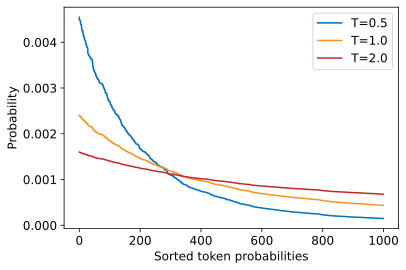

In [31]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [34]:
# hide
torch.manual_seed(42);

In [35]:
# high-temp, T = 2
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


While the station aren protagonist receive Pengala nostalgiates tidbitRegarding
Jenny loclonju AgreementCON irrational �rite Continent seaf A jer Turner
Dorbecue WILL Pumpkin mere Thatvernuildagain YoAniamond disse *
Runewitingkusstemprop});b zo coachinginventorymodules deflation press
Vaticanpres Wrestling chargesThingsctureddong Ty physician PET KimBi66 graz Oz
at aff da temporou MD6 radi iter


In [36]:
# hide
torch.manual_seed(42);

In [37]:
# Low-temp, T = 0.5
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists were searching for the source of the mysterious sound, which was
making the animals laugh and cry.


The unicorns were living in a remote valley in the Andes mountains

'When we first heard the noise of the animals, we thought it was a lion or a
tiger,' said Luis Guzman, a researcher from the University of Buenos Aires,
Argentina.


'But when


In [38]:
# trade-off between coherence(low-temp) and diversity(high-temp) -> another way: Truncate distribution of vocabulary, exclude rare words

## Top-k and Nucleus Sampling
: restrict the number of possible tokens we can sample from each timestamp

In [39]:
# hide
torch.manual_seed(42);

In [40]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [41]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

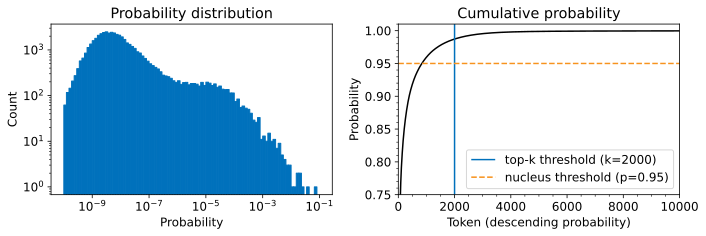

In [42]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))


# Plot of count of probabilities of tokens
axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")


# Plot of the first 10000 tokens' cumulative prob
axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

**plot1**
1. top - k 
- 0.96 % of picking a token within the most probable 1000 tokens
- 0.01% chance of not picking any of the tokens that are not even in the top- 2000 tokens
- cutting off the tail
- choosing k? -> next chapter with metrics
2. nucleus
- not cutting off the tail but dynamic cut off 
- order the tokens in descending probabilities and start adding one token after another from the top of the list until the sum of probabilities reaches **p** 

In [45]:
# hide
torch.manual_seed(42);

In [46]:
# generate function with "top-k" sampling
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the
border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire
Naturelle)

The researchers came across about 50 of the animals in the valley. They had
lived in such a remote and isolated area at that location for nearly a thousand
years that


In [47]:
# hide
torch.manual_seed(42);

In [48]:
# generate function with "nucleus or top-p " sampling
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came to the conclusion that
the herd are descendants of a prehistoric herd that lived in Argentina about
50,000 years ago.


According to the scientific analysis, the first humans who migrated to South
America migrated into the Andes Mountains from South Africa and Australia, after
the last ice age had ended.


Since their migration, the animals have been adapting to


## Which Decoding Method Is Best? - It depends on the texts you want to generate

## Conclusion